# ICLR Reproducability Challenge: Interactive Report

## Gradients Explode - Deep Networks Are Shallow - ResNets Explained

This is an interactive report that contains code to reproduce some of the experiments from the paper



## Introduction

The original paper sets out to show that techniques such as Adam, batch normalisation and SeLU nonlinearities do not solve the exploding gradient problem that MLPs can suffer from. The authors go on to show that exploding gradients limit the depth to which neural networks can be effectively trained. The authors introduce the gradient scale coefficient and propose that it is used as a standard metric for exploding gradients.

## Notation

#### Neural Network Notation

The authors describe a neural network $f$ as a succession of layers $f_l$, $ 0 \leq l \leq L$. Each of these layers is a vector-to-vector transformation. $f_1$ is the final/output layer, which outputs the prediction of the network, i.e:

\begin{equation*}
\hat{y} = f_1(\theta_1, f_2(\theta_2, f_3(\dots f_L(\theta_L, x)\dots)))
\end{equation*}

The goal is to minimise the value of the error/loss layer $f_0$ over the network's prediction and the true label $y$, summed over some dataset $D$.

\begin{equation*}
\underset{\theta}{\operatorname{argmin}} E = \frac{1}{|D|}\sum_{(x,y)\in D}f_0(y, f_1(\theta_1, f_2(\theta_2, f_3(\dots f_L(\theta_L, x)\dots))))
\end{equation*}

#### Quadratic Expectation

Let the quadratic expectation $\mathbb{Q}$ of a random variable $X$ be defined as

\begin{equation*}
\mathbb{Q}[X] = \mathbb{E}[X^2]^{\frac{1}{2}}
\end{equation*}

This is the generalisation of quadratic mean to random variables. Let the inverse quadratic expectation $\mathbb{Q}^{-1}$ of a random variable $X$ be defined as

\begin{equation*}
\mathbb{Q}^{-1}[X] = \mathbb{E}[X^{-2}]^{-\frac{1}{2}}
\end{equation*}

#### Quadratic Mean Norm

Let the quadratic mean norm or qm norm of an $m \times n$ matrix $A$ be the quadratic mean of its singular values where the sum of squares is divided by its right dimension $n$. If $s_1, s_2, \dots, s_{\mathrm{min}(m,n)}$ are the singular values of $A$, we write:

\begin{equation*}
||A||_{qm} = \sqrt{\frac{s_1^2 + s_2^2 + \cdots + s_{\mathrm{min}(m,n)}^2}{n}}
\end{equation*}

It measures the expected impact the matrix has on the length of a vector with uniformly random orientation

#### Jacobians

Let $\mathcal{J}_k^l(\theta, x, y)$ be the Jacobian of the $l$th layer $f_l$ with respect to the $k$th layer $f_k$ evaluated with parameter $\theta$ at $(x,y)$, where $0 \leq l \leq k \leq L$

Let $\mathcal{T}_k^l(\theta, x, y)$ be the Jacobian of the $l$th layer $f_l$ with respect to the parameter sub-vector of the $k$th layer $\theta_k$

## Gradient Scale Coefficients (GSCs)

The authors propose the Gradient Scale Coefficient as a means of assessing whether a network has pathological exploding gradients. It is robust to network scaling and layer width and can be used directly to show that training is difficult.

#### GSC Definition

Let the gradient scale coefficient for $0 \leq l \leq k \leq L$ be as follows:

\begin{equation*}
GSC(k,l,f,\theta,x,y) = \frac{||\mathcal{J}_k^l||_{qm}^2||f_k||_2^2}{||f_l||_2^2}
\end{equation*}

The GSC combines the norm of the Jacobian with the ratio of the lengths of the forward activation
vectors. In plain language, it measures the size of the gradient flowing backward relative to the size
of the activations flowing forward. Equivalently, it measures the relative sensitivity of layer l with
respect to small random changes in layer k

#### Exploding Gradients

The authors propose the following definition of exploding gradients using the GSC. The network $f(\theta)$ has exploding gradients with rate $r$ and intercept $c$ at some point $(x,y)$ if for all $k$ and $l$ we have $GSC(k,l,f,\theta,x,y) \geq cr^{k-l}$, and in particular $GSC(l,0,f,\theta,x,y) \geq cr^{l}$

## Residual Neural Network and ResNets
Similar to a standard neural network, the authors introduce the concept of a residual neural network which akin to the traditional neural network, referred to in the paper as a 'vanilla network' is a succession of layers with $f_1$ as the final/output layer. Each layer, apart from $f_0$, the error layer, is the sum of a fixed initial function $i_l$ and a residual function $r_l$. Here, the prediction of the network is

\begin{equation*}
\hat{y} = f_1(i_1 + r_1(\theta_1), f_2(i_2 + r_2(\theta_2), f_3(\dots f_L(i_L + r_L(\theta_L), x)\dots)))
\end{equation*}

This is minimised in a similar fashion to a vanilla network, by minimising the loss on the error layer, $f_0$

#### ResNets
ResNets are a special subset of residual neural networks which use a skip connection where an output from one layer $f_i$ is fed into the input of another layer $f_{i+x}$ along with the output of $f_{i+x-1}$. This is known as a residual block and $x$ is typically equal to 2 or 3. It can therefore be seen that the residual function is simply
\begin{equation*}
r_l(\theta_l) = f_l(\theta_l) + f_{l-x}(\theta_{l-x})
\end{equation*}

More generally, we can refer to $f_b$
\begin{equation*}
f_b = \rho_b + s_b
\end{equation*}

Where $\rho_b$ is value computed by the block function and $s_b$ is the value computed by the skip connection. We point to a concept $k$ where

\begin{equation*}
k \propto \frac{||s_b||}{||\rho_b||}
\end{equation*}

It is therefore said that $f_b$ is $k$-diluted. Diluting the function by a factor of $k$ does not just reduce the growth of the GSC by a factor of $k$ but by a factor of $k^2 + 1$. A reduction in the GSC this large shows how even small dilutions can drastically reduce the problem of exploding gradients

# Experiments

## Gradients Explode - Despite Bounded Activation Functions (Approx Runtime: 30 minutes)

In this first experiment, the authors show that exploding gradients exist in MLPs despite the presence of bounded activation functions. They test 7 different MLPs: one with ReLU activations; one with layer normalisation followed by ReLU; one with batch normalisation followed by ReLU; one with tanh activations; one with layer normalisation followed by tanh; one with batch normalisation followed by tanh and one with SeLU activations. All 7 networks had 50 layers with 100 neurons each. The inputs and labels were gaussian noise.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys

In [0]:
class MLP(nn.Module):
    """
    Creates an MLP with a built-in method to compute it's gradient
    scale coefficients
    """
    
    def __init__(self, activation, layer_norm=False, batch_norm=False):
        super(MLP, self).__init__()
        if layer_norm and batch_norm:
            raise MemoryError('Only one of layer norm and batch norm' + \
                              ' can be true')
        self.activation = activation
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm
        self.layers = nn.ModuleList()
        for i in range(50):
            self.layers.append(nn.Linear(100, 100, bias=False))
        if self.activation == F.relu:
            for layer in self.layers:
                layer.weight.data = torch.tensor(2/100).pow(0.5)*torch.randn((100,100))
        elif self.activation == torch.tanh:
            for layer in self.layers:
                layer.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn((100,100))
        elif self.activation == torch.selu:
            for layer in self.layers:
                layer.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn((100,100))
    
    def forward(self, x):
        if self.layer_norm:
            for i in range(len(self.layers)):
                x = self.activation(self.lnorm(self.layers[i](x)))
        elif self.batch_norm:
            for i in range(len(self.layers)):
                x = self.activation(self.bnorm(self.layers[i](x)))
        else:
            for i in range(len(self.layers)):
                x = self.activation(self.layers[i](x))
        return x
    
    def bnorm(self, x):
        mu = x.mean(dim=0)
        sigma = x.std(dim=0)
        x = (x - mu) / sigma
        return x
    
    def lnorm(self, x):
        mu = x.mean(dim=1).view(x.size(0),1)
        sigma = x.std(dim=1).view(x.size(0),1)
        x = (x - mu) / sigma
        return x
    
    def get_gsc(self, k, l, x, y):
        """
        Computes the gradient scale coefficient for layers k and l for
        input x and target y
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        intermediates = []
        batch_size = x.size(0)
        x = x.clone().detach().requires_grad_(True)
        if self.layer_norm:
            for i in range(len(self.layers)):
                x = self.activation(self.lnorm(self.layers[i](x)))
                intermediates.append(x)
        if self.batch_norm:
            for i in range(len(self.layers)):
                x = self.activation(self.bnorm(self.layers[i](x)))
                intermediates.append(x)
        else:
            for i in range(len(self.layers)):
                x = self.activation(self.layers[i](x))
                intermediates.append(x)
        x = torch.mul(x,y).sum(1)
        intermediates.append(x)
        intermediates = intermediates[::-1]
        
        fl = intermediates[l]
        fk = intermediates[k]
        
        if l != 0:
            fl_dim = fl.size(1)
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.zeros((fl_dim, fk_dim))
                for i in range(fl_dim):
                    J[i] += torch.autograd.grad(intermediates[l][b][i],
                                                intermediates[k],
                                                retain_graph=True)[0].flatten()
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        else:
            fl_dim = 1
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.autograd.grad(intermediates[l][b],
                                        intermediates[k],
                                        retain_graph=True)[0]
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        qe_J_norm = self.quadratic_expectation(J_norms)
        qe_k_norm = self.quadratic_expectation(k_norms)
        qe_l_norm = self.quadratic_expectation(l_norms)
        gsc = (qe_J_norm * qe_k_norm) / qe_l_norm
        return gsc
    
    def get_stds(self, x, y):
        """
        Computes the pre activation standard deviations
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        stds = torch.zeros(50)
        signs = torch.zeros(50)
        batch_size = x.size(0)
        if self.layer_norm:
            for i in range(len(self.layers)):
                x = self.lnorm(self.layers[i](x))
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        elif self.batch_norm:
            for i in range(len(self.layers)):
                x = self.bnorm(self.layers[i](x))
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        else:
            for i in range(len(self.layers)):
                x = self.layers[i](x)
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        return stds, signs
    
    def l2_norm(self, a):
        """
        Computes the L2 norm of vector a, i.e. square root of the sum of each
        element of a squared
        """
        norm = a.pow(2).sum().pow(0.5)
        return norm
    
    def qm_norm(self, A):
        """
        Computes the quadratic mean norm of matrix A
        """
        U, s, V = torch.svd(A)
        sum_sq = s.pow(2).sum()
        norm = torch.sqrt(sum_sq / A.size(1))
        return norm
    
    def quadratic_expectation(self, x):
        """
        Computes the quadratic mean norm of vector x
        """
        expectation = x.pow(2).mean().pow(0.5)
        return expectation

def generate_dataset(obs, mean, var):
    x = mean + (var**0.5)*torch.randn((obs, 100))
    x = 10 * x / x.pow(2).sum(1).pow(0.5).view(obs, 1)
    y = mean + (var**0.5)*torch.randn((obs, 100))
    return x, y

Dataset 10	Network 7	Depth: 50	ETA = 00:30:26

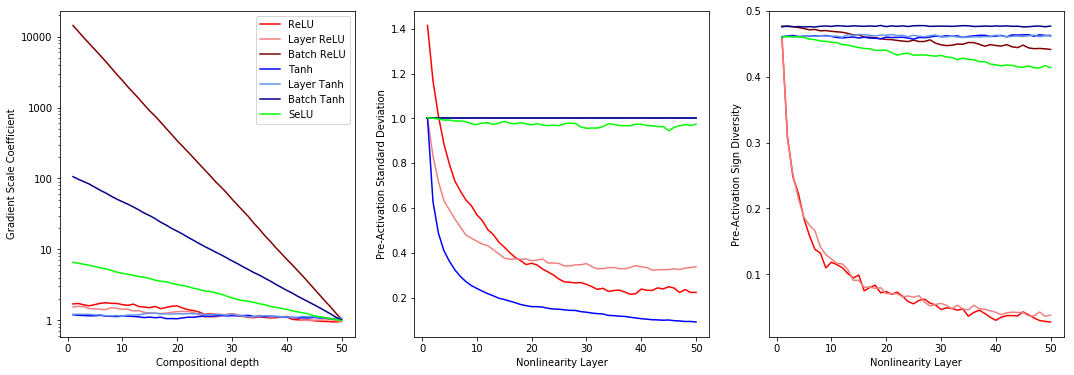

In [0]:
import time
import numpy as np

# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = 'cpu'
num_datasets = 10
activations = [F.relu, F.relu, F.relu, torch.tanh, torch.tanh, torch.tanh, torch.selu]
layer_norms = [False, True, False, False, True, False, False]
batch_norms = [False, False, True, False, False, True, False]
labels = ['ReLU', 'Layer ReLU', 'Batch ReLU', 'Tanh', 'Layer Tanh', 'Batch Tanh', 'SeLU']
colours = ['r', 'lightcoral', 'maroon', 'b', 'cornflowerblue', 'darkblue', 'lime']
gscs = np.zeros((num_datasets, len(activations), 50))
stds = np.zeros((num_datasets, len(activations), 50))
signs = np.zeros((num_datasets, len(activations), 50))

start = time.time()
for i in range(num_datasets):
    inputs, targets = generate_dataset(100, 0, 1/100)
    inputs = inputs.to(device)
    targets = targets.to(device)
    for j in range(len(activations)):
        network = MLP(activations[j],
                      layer_norms[j],
                      batch_norms[j]).to(device)
        for k in range(1,51):
            gscs[i][j][k-1] += network.get_gsc(k, 0, inputs, targets).cpu().item()
            proportion = i/num_datasets + \
            j/(num_datasets*len(activations)) + \
            k/(num_datasets*len(activations)*50)
            now = time.time()
            approx_remaining = (now - start) / proportion
            hours = int(approx_remaining - (now - start)) // 60**2
            minutes = int(approx_remaining - (now - start) - hours*60**2) // 60
            seconds = int(approx_remaining - (now - start) - hours*60**2 - minutes*60)
            sys.stdout.write('\rDataset %d\tNetwork %d\tDepth: %d\tETA = %02d:%02d:%02d' % \
                             (i+1, j+1, k, hours, minutes, seconds))
            sys.stdout.flush()
        std, sign = network.get_stds(inputs, targets)
        stds[i][j] += std.data.numpy()
        signs[i][j] += sign.data.numpy()

gscs = gscs.mean(axis=0)
stds = stds.mean(axis=0)
signs = signs.mean(axis=0)
end = time.time()

depths = 50 - np.arange(50)
layers = np.arange(50) + 1
fig, ax = plt.subplots(figsize=(18,6), nrows=1, ncols=3)
for i in range(len(activations)):
    ax[0].plot(depths, gscs[i], label=labels[i], c=colours[i])
    ax[1].plot(layers, stds[i], label=labels[i], c=colours[i])
    ax[2].plot(layers, signs[i], label=labels[i], c=colours[i])
ax[0].set_yscale('log')
ax[0].set_yticks([1,10,100,1000,10000])
ax[0].set_yticklabels([1,10,100,1000,10000])
ax[0].set_xlabel('Compositional depth')
ax[0].set_ylabel('Gradient Scale Coefficient')
ax[0].legend()
ax[1].set_xlabel('Nonlinearity Layer')
ax[1].set_ylabel('Pre-Activation Standard Deviation')
ax[2].set_xlabel('Nonlinearity Layer')
ax[2].set_ylabel('Pre-Activation Sign Diversity')
plt.show()

## Timer may be broken ##

Our results for the pre-activation standard deviations and sign diversities roughly match those reported in the paper. However, in our reproduction, the GSC for the Layer-tanh MLP did not increase exponentially. This suggests that our Layer-tanh MLP did not have exploding gradients. Its relatively constant pre-activation standard deviations and sign-diversities suggest that it also does not suffer from the collapsing domain problem. This result is very peculiar, since common intuition suggests that a regular 50 layer MLP with tanh and layer normalisation would be difficult to train and therefore would most likely exhibit signs of either exploding gradients or a collapsing domain. Other than this result, our reproduction of Figure 1(A) matches the original closely.

When we reproduced this experiment we found that calculating the GSCs for 100 datasets of 10000 observations was impractical for our setup. It took us roughly 30 minutes to run the experiment with 10 datasets of 100 observations (1000 times fewer total observations than in the paper). The costly part of the experiment was computing the Jacobians of the loss with respect to each layer. Bizarrely, we found that disabling GPU acceleration and running on CPU made this experiment faster.

## Exploding Gradients Limit Depth - The Residual Trick (Approx Runtime: 2-3 hours for 100 epochs)

The authors introduce the concept of effective depth in a network. They state that by the time the gradient has propagated back to the first layer, it will be a sum of terms that are almost all a product of $\frac{L}{2}$ residual Jacobian matrices. If the operator norm of the residual Jacobians is less than $p$ for $p < 1$, then the norm of products of residual Jacobians will decrease exponentially in the number of residual Jacobians they contain. They claim that the information required for sets of $\lambda$ or more layers to co-adapt during training is contained in terms that are a product of at least $\lambda$ residual Jacobians. Therefore, they claim that the effective depth of a network is the largest $\lambda$ such that the sum of all terms containing $\lambda$ residual Jacobians is non-negligible. The authors try to show that if a network has exploding gradients as shown by GSC, the number of updates required to train that network to have effective depth $\lambda$ will increase exponentially. Hence, exploding gradients limit effective depth.

To test this idea, the authors trained the four exploding architectures from the previous experiment on the CIFAR10 dataset. Each MLP contained 51 linear layers with 100 neurons each, except for the input and output layers. A softmax was placed just before the error layer. The authors used a KL error layer, which computes the logarithm of the predicted probability of the correct class. They tested several initial learning rates to find the optimal learning rate for each network. The given set of step sizes given for testing were \{$1\mathrm{e}{5}$, $3\mathrm{e}{4}$, $1\mathrm{e}{4}$, $3\mathrm{e}{3}$..., $1\mathrm{e}{-4}$, $3\mathrm{e}{-5}$, $1\mathrm{e}{-5}$\}. For each of these step sizes, each network was trained for 500 epochs where if after 5 epochs, the training error did not decrease the learning rate was multiplied by 0.333. In the end, the step size that achieved the lowest training error was chosen as optimal.

We ran into difficulties when reproducing this experiment. To get the optimal initial learning rates for each network, we tested each one for 70 epochs instead of 500 as doing the full 500 would have been impractical with our setup. The authors tested initial learning rates as high as $1\mathrm{e}{5}$, which seemed like a waste of time. The high initial learning rates caused the loss to increase and to eventually become a NaN as one would expect. The authors never explained why they used the KL error layer instead of categorical cross entropy. It seems like an inferior choice, since the KL loss only depends on one of the predicted probabilities, whereas categorical cross entropy depends on all 10 predicted probabilities and therefore weight updates computed using cross entropy will adjust all 10 predictions instead of just one each update. Using all 50000 images in the training set to calculate $GSC(L,0)$ and calculate the effective depth was far too time consuming on our setup and in some cases used up all of our RAM, causing our sessions to crash. We suspect that attempting to store all the information from a backward pass as well as the Jacobians between layers used to compute the GSCs were what caused these memory issues. We settled on using only 100 images to compute $GSC(L,0)$ for each network and effective depth for only SeLU. Additionally, we only trained each network for 100 epochs instead of 500, however this experiment still took us several hours to run.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import time

In [0]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
    transforms.Lambda(lambda x: x.view(-1))
])

trainset = CIFAR10(".", train=True, download=True, transform=transform)
smallset = CIFAR10(".", train=True, download=True, transform=transform)

0it [00:00, ?it/s]

100%|█████████▉| 170336256/170498071 [00:53<00:00, 8850715.23it/s]

Files already downloaded and verified


In [0]:
import numpy as np
sample_size = 100
sample = np.random.permutation(np.arange(50000))
sample = sample[:sample_size]
smallset.data = smallset.data[sample]

In [0]:
trainloader = DataLoader(trainset, batch_size=1000, shuffle=True)
gscloader = DataLoader(smallset, batch_size=sample_size, shuffle=True)

In [0]:
class MLP(nn.Module):
    """
    Creates an MLP with a built-in method to compute it's gradient
    scale coefficients
    """
    
    def __init__(self, activation, layer_norm=False, batch_norm=False):
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        super(MLP, self).__init__()
        if layer_norm and batch_norm:
            raise MemoryError('Only one of layer norm and batch norm' + \
                              ' can be true')
        self.activation = activation
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm
        self.fc1 = nn.Linear(3072, 100, bias=False)
        self.init_fc1 = nn.Linear(3072, 100, bias=False)
        if self.activation == F.relu:
            weight = torch.tensor(2/100).pow(0.5)*torch.randn(self.fc1.weight.size())
            self.fc1.weight.data = weight
            self.init_fc1.weight.data = weight
        elif self.activation == torch.tanh:
            weight = torch.tensor(1/100).pow(0.5)*torch.randn(self.fc1.weight.size())
            self.fc1.weight.data = weight
            self.init_fc1.weight.data = weight
        elif self.activation == torch.selu:
            weight = torch.tensor(1/100).pow(0.5)*torch.randn(self.fc1.weight.size())
            self.fc1.weight.data = weight
            self.init_fc1.weight.data = weight
        
        self.layers = nn.ModuleList()
        self.init_hidden_layers = nn.ModuleList()
        for i in range(49):
            self.layers.append(nn.Linear(100, 100, bias=False))
            self.init_hidden_layers.append(nn.Linear(100, 100, bias=False))
        if self.activation == F.relu:
            for i in range(len(self.layers)):
                weight = torch.tensor(2/100).pow(0.5)*torch.randn((100,100))
                self.layers[i].weight.data = weight
                self.init_hidden_layers[i].weight.data = weight
        elif self.activation == torch.tanh:
            for i in range(len(self.layers)):
                weight = torch.tensor(1/100).pow(0.5)*torch.randn((100,100))
                self.layers[i].weight.data = weight
                self.init_hidden_layers[i].weight.data = weight
        elif self.activation == torch.selu:
            for i in range(len(self.layers)):
                weight = torch.tensor(1/100).pow(0.5)*torch.randn((100,100))
                self.layers[i].weight.data = weight
                self.init_hidden_layers[i].weight.data = weight
        
        self.fc2 = nn.Linear(100, 10, bias=False)
        self.init_fc2 = nn.Linear(100, 10, bias=False)
        if self.activation == F.relu:
            weight = torch.tensor(2/100).pow(0.5)*torch.randn(self.fc2.weight.size())
            self.fc2.weight.data = weight
            self.init_fc2.weight.data = weight
        elif self.activation == torch.tanh:
            weight = torch.tensor(1/100).pow(0.5)*torch.randn(self.fc2.weight.size())
            self.fc2.weight.data = weight
            self.init_fc2.weight.data = weight
        elif self.activation == torch.selu:
            weight = torch.tensor(1/100).pow(0.5)*torch.randn(self.fc2.weight.size())
            self.fc2.weight.data = weight
            self.init_fc2.weight.data = weight
    
    def forward(self, x):
        if self.layer_norm:
            x = self.activation(self.lnorm(self.fc1(x)))
            for i in range(len(self.layers)):
                x = self.activation(self.lnorm(self.layers[i](x)))
        elif self.batch_norm:
            x = self.activation(self.bnorm(self.fc1(x)))
            for i in range(len(self.layers)):
                x = self.activation(self.bnorm(self.layers[i](x)))
        else:
            x = self.activation(self.fc1(x))
            for i in range(len(self.layers)):
                x = self.activation(self.layers[i](x))
        x = F.softmax(self.fc2(x), dim=1)
        return x
    
    def bnorm(self, x):
        mu = x.mean(dim=0)
        sigma = x.std(dim=0)
        x = (x - mu) / sigma
        return x
    
    def lnorm(self, x):
        mu = x.mean(dim=1).view(x.size(0),1)
        sigma = x.std(dim=1).view(x.size(0),1)
        x = (x - mu) / sigma
        return x
    
    def get_gsc(self, k, l, x, y):
        """
        Computes the gradient scale coefficient for layers k and l for
        input x and target y
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        intermediates = []
        batch_size = x.size(0)
        x = x.clone().detach().requires_grad_(True).to(device)
        if self.layer_norm:
            x = self.activation(self.lnorm(self.fc1(x)))
            intermediates.append(x)
            for i in range(len(self.layers)):
                x = self.activation(self.lnorm(self.layers[i](x)))
                intermediates.append(x)
        elif self.batch_norm:
            x = self.activation(self.bnorm(self.fc1(x)))
            intermediates.append(x)
            for i in range(len(self.layers)):
                x = self.activation(self.bnorm(self.layers[i](x)))
                intermediates.append(x)
        else:
            x = self.activation(self.fc1(x))
            intermediates.append(x)
            for i in range(len(self.layers)):
                x = self.activation(self.layers[i](x))
                intermediates.append(x)
        x = F.softmax(self.fc2(x), dim=1)
        intermediates.append(x)
        x = torch.log(x[torch.arange(y.size(0)),y])
        intermediates.append(x)
        intermediates = intermediates[::-1]
        
        fl = intermediates[l]
        fk = intermediates[k]
        
        if l != 0:
            fl_dim = fl.size(1)
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.zeros((fl_dim, fk_dim))
                for i in range(fl_dim):
                    J[i] += torch.autograd.grad(intermediates[l][b][i],
                                                intermediates[k],
                                                retain_graph=True)[0].flatten().to(device)
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        else:
            fl_dim = 1
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.autograd.grad(intermediates[l][b],
                                        intermediates[k],
                                        retain_graph=True)[0].to(device)
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        qe_J_norm = self.quadratic_expectation(J_norms)
        qe_k_norm = self.quadratic_expectation(k_norms)
        qe_l_norm = self.quadratic_expectation(l_norms)
        gsc = (qe_J_norm * qe_k_norm) / qe_l_norm
        return gsc
    
    def get_stds(self, x, y):
        """
        Computes the pre activation standard deviations
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        stds = torch.zeros(50)
        signs = torch.zeros(50)
        batch_size = x.size(0)
        if self.layer_norm:
            for i in range(len(self.layers)):
                x = self.lnorm(self.layers[i](x))
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        elif self.batch_norm:
            for i in range(len(self.layers)):
                x = self.bnorm(self.layers[i](x))
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        else:
            for i in range(len(self.layers)):
                x = self.layers[i](x)
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        return stds, signs
    
    def l2_norm(self, a):
        """
        Computes the L2 norm of vector a, i.e. square root of the sum of each
        element of a squared
        """
        norm = a.pow(2).sum().pow(0.5)
        return norm
    
    def qm_norm(self, A):
        """
        Computes the quadratic mean norm of matrix A
        """
        U, s, V = torch.svd(A)
        sum_sq = s.pow(2).sum()
        norm = torch.sqrt(sum_sq / A.size(1))
        return norm
    
    def quadratic_expectation(self, x):
        """
        Computes the quadratic mean norm of vector x
        """
        expectation = x.pow(2).mean().pow(0.5)
        return expectation
    
    def residual(self, x, xi):
        return x - xi
    
    def get_residual_matrix(self, x, l):
        l = 49 - (l+1)
        #initial = self.initial(F.selu(self.init_fc1(x)), l)
        #current = self.between(x, l)
        initial = self.init_hidden_layers[l].weight.data
        current = self.layers[l].weight.data
        return self.residual(current, initial)
    
    def get_operator_norm(self, residual_matrix):
        numpy_residual = residual_matrix.cpu().numpy()
        multiplied = numpy_residual.transpose().dot(numpy_residual)
        max_singular_value = np.linalg.norm(multiplied,2)
        return torch.from_numpy(np.array(np.sqrt(max_singular_value)))

Architecture 5	Epoch 68	loss 2.30	acc 0.10	gsc 0.00

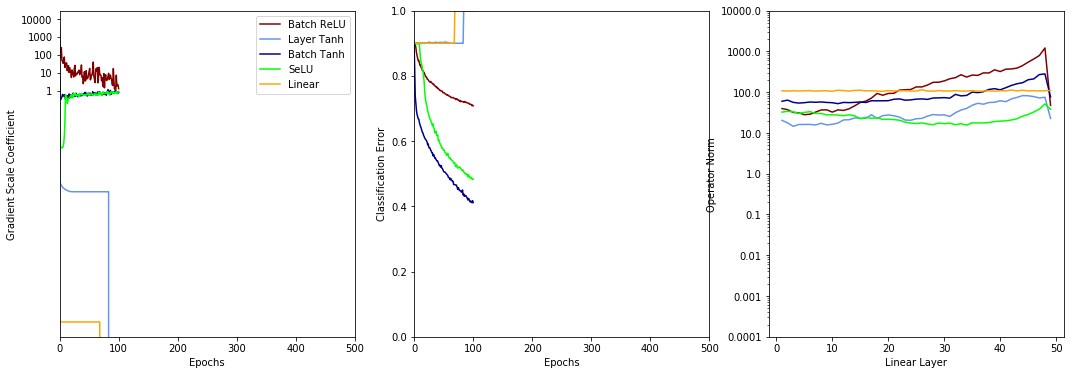

Finished in 0 hours, 0 minutes, 0 seconds


In [0]:
from sklearn.metrics import accuracy_score
import torch.optim as optim

device = "cuda:0" if torch.cuda.is_available() else "cpu"
activations = [F.relu, torch.tanh, torch.tanh, torch.selu]
layer_norms = [False, True, False, False]
batch_norms = [True, False, True, False]
step_sizes = [0.03, 0.1, 0.3, 0.03]
epochs = 100
gscs = np.zeros((len(activations), epochs+1))
accs = np.zeros((len(activations), epochs+1))
op_norms = np.zeros((len(activations),49))

start = time.time()
for i in range(len(activations)):
    network = MLP(activations[i], layer_norms[i], batch_norms[i]).to(device)
    optimiser = optim.SGD(network.parameters(), lr=step_sizes[i])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', 0.333, 5)
    lr_changes = 0
    prev_lr = step_sizes[i]
    running_loss = 0

    for data in gscloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        gscs[i][0] += network.get_gsc(51, 0, inputs, labels)
    
    running_loss = 0.0
    running_acc = 0.0
    num_batches = 0.0
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimiser.zero_grad()
        outputs = network(inputs)
        values, indices = torch.max(outputs, 1)
        running_acc += accuracy_score(labels.cpu(), indices.cpu())
        num_batches += 1
        loss = -1*torch.log(outputs[torch.arange(labels.size(0)),labels]).mean()
        running_loss += loss.item()
        network.zero_grad()
    running_acc /= num_batches
    running_loss /= num_batches
    accs[i][0] += running_acc

    for epoch in range(epochs):
        start = time.time()
        if lr_changes >= 11:
            break
        running_loss = 0.0
        running_acc = 0.0
        num_batches = 0.0
        for param_group in optimiser.param_groups:
                if prev_lr != param_group['lr']:
                    lr_changes += 1
                    prev_lr = param_group['lr']
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimiser.zero_grad()
            outputs = network(inputs)
            values, indices = torch.max(outputs, 1)
            running_acc += accuracy_score(labels.cpu(), indices.cpu())
            num_batches += 1
            loss = -1*torch.log(outputs[torch.arange(labels.size(0)),labels]).mean()
            loss.backward()
            optimiser.step()
            running_loss += loss.item()
            network.zero_grad()
        for data in gscloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            gsc = network.get_gsc(51, 0, inputs, labels)
            gscs[i][epoch+1] += gsc
        scheduler.step(running_loss)
        running_acc /= num_batches
        running_loss /= num_batches
        accs[i][epoch+1] += running_acc
        proportion = i/len(activations) + (epoch+1)/(epochs*len(activations))
        sys.stdout.write("\rArchitecture %d\tEpoch %d\tloss %4.2f\tacc %4.2f\tgsc %4.2f" % \
                         (i+1, epoch+1, running_loss, running_acc, gsc))
        sys.stdout.flush()
        
        network.eval()
        for j in range(1,50):
            for data in trainloader:
                inputs2, labels2 = data
                inputs2, labels2 = inputs2.to(device), labels2.to(device)
                residual_matrix = network.get_residual_matrix(inputs2, j)
                operator_norm = network.get_operator_norm(residual_matrix)
                op_norms[i][j-1] += operator_norm
                break

end = time.time()
duration = end - start
hours = int(duration) // (60**2)
minutes = int(duration - hours*(60**2)) // 60
seconds = int(duration - hours*(60**2) - minutes*60)

labels = ['Batch ReLU', 'Layer Tanh', 'Batch Tanh', 'SeLU']
colours = ['maroon', 'cornflowerblue', 'darkblue', 'lime']
epochs = np.arange(epochs+1)
depths = np.arange(49) + 1
layers = np.arange(50) + 1
fig, ax = plt.subplots(figsize=(18,6), nrows=1, ncols=3)
for i in range(len(activations)):
    ax[0].plot(epochs, 1-accs[i], label=labels[i], c=colours[i])
    ax[1].plot(epochs, gscs[i], label=labels[i], c=colours[i])
    ax[2].plot(depths, op_norms[i], label=labels[i], c=colours[i])
ax[0].set_xlim([0,500])
ax[0].set_ylim([0,1])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Classification Error')
ax[0].legend()
ax[1].set_yscale('log')
ax[1].set_yticks([1,10,100,1000,10000])
ax[1].set_yticklabels([1,10,100,1000,10000])
ax[1].set_xlim([0,500])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Gradient Scale Coefficient')
ax[2].set_yscale('log')
ax[2].set_ylim([0.0001,10])
ax[2].set_yticks([0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0])
ax[2].set_yticklabels([0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0])
ax[2].set_xlabel('Linear Layer')
ax[2].set_ylabel('Operator Norm')
plt.show()

print('Finished in %d hours, %d minutes, %d seconds' % (hours, minutes, seconds))

## Timer is broken (apparently layer-tanh is as well)##

Our classification errors over 100 epochs for batch-tanh and SeLU are similar to those obtained in the paper, except swapped around. We had significantly higher error with batch-ReLU. These discrepancies may have happened because we used 70 epochs to find optimal initial step sizes. After around 80 epochs, the GSCs for layer-tanh became 0 and the error became 100\%. We are not sure why this happened. Our $GSC(L,0)$ results do not match those reported in the paper. From their results, the authors conclude that when layers are trained jointly, there is no evidence that the GSC increases or decreases during training. However, our results (apart from layer-tanh) seem to suggest that the GSC tends to converge towards 1 during training. In addition, in architectures where the GSC converged to roughly 1, classification error decreased faster. This may be coincidental, but is an interesting pattern nonetheless. Our effective depth results were different. The values of the residual Jacobian matrices depend on the inputs, and vary more if fewer images are used. This noisiness may have prevented us from observing a consistent increase in the effective depth throughout training, however the effective depth never reached the total amount of layers which supports the idea that layers cannot co-adapt for sufficiently deep networks when exploding gradients are present. The operator norms we attained were not completely the same, but followed the same trends. Each architecture except SeLU showed a downward trend from the error layer, but at much higher values than in the paper. The weights of the later layers changed much more than the earlier layers during training. This suggests that if these exploding networks were to become any deeper, their effective depth would not increase.

## ResNet reduces the gradient - And ResNet explained

The authors demonstrate in this experiment that GSCs for ResNets are significantly lower than standard MLPs. On top of this, the rate of domain collapse is significantly lower for layer-ReLU. As in section 1, the same experiments are used. The first layer of the network is a linear layer followed by 25 skip connections, each of which bypasses a block of 6 layers: 'a normalization layer, a nonlinearity layer, a linear layer, another normalization layer, another nonlinearity layer, and another linear layer. Above the last skip connection, a final normalization layer is inserted, followed by softmax'. Skip connections use the identify function.



In [0]:
class Bottleneck(nn.Module):

    def bnorm(self, x):
        mu = x.mean(dim=0)
        sigma = x.std(dim=0)
        x = (x - mu) / sigma
        return x
    
    def lnorm(self, x):
        mu = x.mean(dim=1).view(x.size(0),1)
        sigma = x.std(dim=1).view(x.size(0),1)
        x = (x - mu) / sigma
        return x
      
    def nonorm(self, x):
        return x
    
    def __init__(self, activation, layer_norm=False, batch_norm=False):
        super(Bottleneck, self).__init__()
        
        self.activation = activation
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm
        
        self.lin1 = nn.Linear(100, 100, bias=False)
        self.lin2 = nn.Linear(100, 100, bias=False)
        self.lin3 = nn.Linear(100, 100, bias=False)
        self.lin4 = nn.Linear(100, 100, bias=False)
        
        self.norm = self.lnorm if layer_norm else (self.bnorm if batch_norm else self.nonorm)

    def forward(self, x):
        out = self.norm(x)

        out = self.lin1(out)
        out = self.activation(out)

        out = self.lin2(out)

        out = self.norm(out)

        out = self.activation(self.lin3(out))

        out = self.lin4(out)

        out += x  # identity layer
        return out
      
class BottleneckBlockOne(nn.Module):

    def bnorm(self, x):
        mu = x.mean(dim=0)
        sigma = x.std(dim=0)
        x = (x - mu) / sigma
        return x
    
    def lnorm(self, x):
        mu = x.mean(dim=1).view(x.size(0),1)
        sigma = x.std(dim=1).view(x.size(0),1)
        x = (x - mu) / sigma
        return x
      
    def nonorm(self, x):
        return x
    
    def __init__(self, activation, layer_norm=False, batch_norm=False):
        super(BottleneckBlockOne, self).__init__()
        
        self.activation = activation
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm
        
        self.lin1 = nn.Linear(100, 100, bias=False)
        self.lin2 = nn.Linear(100, 100, bias=False)
        self.lin3 = nn.Linear(100, 100, bias=False)
        self.lin4 = nn.Linear(100, 100, bias=False)
        
        self.norm = self.lnorm if layer_norm else (self.bnorm if batch_norm else self.nonorm)

    def forward(self, x):
        out = self.norm(x)
        out = self.lin1(out)
        out = self.activation(out)
        out = self.lin2(out)
        return out
      
class BottleneckBlockTwo(nn.Module):

    def bnorm(self, x):
        mu = x.mean(dim=0)
        sigma = x.std(dim=0)
        x = (x - mu) / sigma
        return x
    
    def lnorm(self, x):
        mu = x.mean(dim=1).view(x.size(0),1)
        sigma = x.std(dim=1).view(x.size(0),1)
        x = (x - mu) / sigma
        return x
      
    def nonorm(self, x):
        return x
    
    def __init__(self, activation, layer_norm=False, batch_norm=False):
        super(BottleneckBlockTwo, self).__init__()
        
        self.activation = activation
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm
        
        self.lin1 = nn.Linear(100, 100, bias=False)
        self.lin2 = nn.Linear(100, 100, bias=False)
        self.lin3 = nn.Linear(100, 100, bias=False)
        self.lin4 = nn.Linear(100, 100, bias=False)
        
        self.norm = self.lnorm if layer_norm else (self.bnorm if batch_norm else self.nonorm)

    def forward(self, x):
        out = self.norm(x)
        out = self.activation(self.lin3(out))
        out = self.lin4(out)
        return out


class ResNet(nn.Module):
    """
    Creates an ResNet extending the MLP class
    """
    
    def bnorm(self, x):
        mu = x.mean(dim=0)
        sigma = x.std(dim=0)
        x = (x - mu) / sigma
        return x
    
    def lnorm(self, x):
        mu = x.mean(dim=1).view(x.size(0),1)
        sigma = x.std(dim=1).view(x.size(0),1)
        x = (x - mu) / sigma
        return x
      
    def nonorm(self, x):
        return x
    
    def __init__(self, activation, layer_norm=False, batch_norm=False):
        super(ResNet, self).__init__()
        
        if layer_norm and batch_norm:
            raise MemoryError('Only one of layer norm and batch norm' + \
                              ' can be true')
        self.activation = activation
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm
        
        self.norm = self.lnorm if layer_norm else (self.bnorm if batch_norm else self.nonorm)
        
        self.layers = []
        
        for i in range(25):
            self.layers.append(nn.Sequential(Bottleneck(activation, layer_norm, batch_norm).to(device)))
            
        self.split_layers = []
        
        for i in range(25):
            self.split_layers.append(nn.Sequential(BottleneckBlockOne(activation, layer_norm, batch_norm).to(device)))
            self.split_layers.append(nn.Sequential(BottleneckBlockTwo(activation, layer_norm, batch_norm).to(device)))
        
        self.lin = nn.Linear(100, 100)

    def forward(self, x):
        out = self.lin(x)
        
        for layer in self.layers:
            out = layer(out)
        
        out = self.norm(out)
        return out
      
    def get_gsc(self, k, l, x, y):
        """
        Computes the gradient scale coefficient for layers k and l for
        input x and target y
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        intermediates = []
        batch_size = x.size(0)
        x = x.clone().detach().requires_grad_(True)
        
        x = self.lin(x)
        out = x
        k_calc = []
        for i in range(len(self.split_layers)):
            out = self.split_layers[i](out)
            intermediates.append(x)
            k_calc = self.qm_norm(x) / self.qm_norm(out)
            if i % 2 == 1:
                out += x
                x = out
        x = self.norm(x)
        
        x = torch.mul(x,y).sum(1)
        intermediates.append(x)
        intermediates = intermediates[::-1]
        
        fl = intermediates[l]
        fk = intermediates[k]
        
        if l != 0:
            fl_dim = fl.size(1)
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.zeros((fl_dim, fk_dim))
                for i in range(fl_dim):
                    J[i] += torch.autograd.grad(intermediates[l][b][i],
                                                intermediates[k],
                                                retain_graph=True)[0].flatten()
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        else:
            fl_dim = 1
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.autograd.grad(intermediates[l][b],
                                        intermediates[k],
                                        retain_graph=True)[0]
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        qe_J_norm = self.quadratic_expectation(J_norms)
        qe_k_norm = self.quadratic_expectation(k_norms)
        qe_l_norm = self.quadratic_expectation(l_norms)
        gsc = (qe_J_norm * qe_k_norm) / qe_l_norm
        
        r = gsc  # TODO what is r exactly. It is GSC(l+1, l)??

        gsc_corr = 1 + (1 + k^2) / (r - 1)
        
        return gsc, gsc_corr
    
    def get_stds(self, x, y):
        """
        Computes the pre activation standard deviations
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        stds = torch.zeros(50)
        signs = torch.zeros(50)
        batch_size = x.size(0)
        
        x = self.lin(x)
        out = x
        for i in range(len(self.split_layers)):
            out = self.split_layers[i](out)
            neuron_stds = x.std(0)
            layer_stds = self.quadratic_expectation(neuron_stds)
            stds[i] = layer_stds
            positive = (x >= 0).sum(0).float()/batch_size
            negative = (x < 0).sum(0).float()/batch_size
            diversity = torch.min(positive, negative).mean()
            signs[i] = diversity
            if i % 2 == 1:
                out += x
                x = out


        return stds, signs
    
    def l2_norm(self, a):
        """
        Computes the L2 norm of vector a, i.e. square root of the sum of each
        element of a squared
        """
        norm = a.pow(2).sum().pow(0.5)
        return norm
    
    def qm_norm(self, A):
        """
        Computes the quadratic mean norm of matrix A
        """
        U, s, V = torch.svd(A)
        sum_sq = s.pow(2).sum()
        norm = torch.sqrt(sum_sq / A.size(1))
        return norm
    
    def quadratic_expectation(self, x):
        """
        Computes the quadratic mean norm of vector x
        """
        expectation = x.pow(2).mean().pow(0.5)
        return expectation
      
def gen_dataset(obs, mean, var):
    x = mean + (var**0.5)*torch.randn((obs, 100))
    x = 10 * x / x.pow(2).sum(1).pow(0.5).view(obs, 1)
    y = mean + (var**0.5)*torch.randn((obs, 100))
    return x, y

Network 7	Depth: 50    

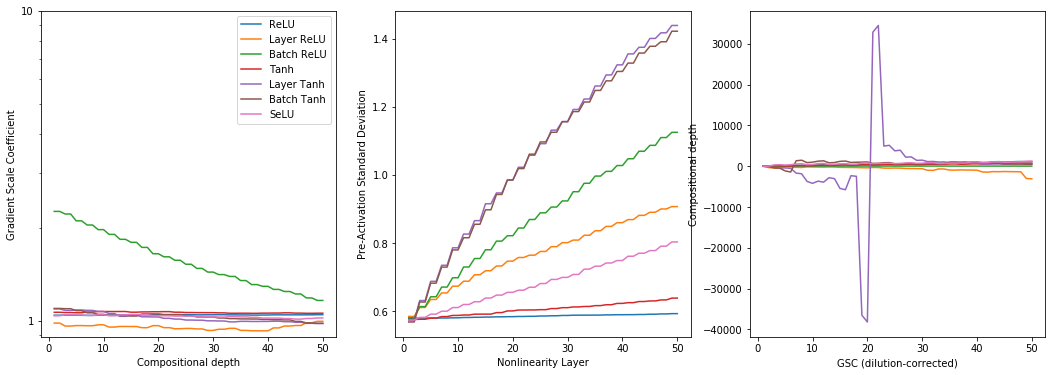

In [0]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
inputs, targets = gen_dataset(100, 0, 1/100)
inputs = inputs.to(device)
targets = targets.to(device)
depths = []
layers = []
gscs = []
gscs_corrected = []
stds = []
signs = []
activations = [F.relu, F.relu, F.relu, torch.tanh, torch.tanh, torch.tanh, torch.selu]
layer_norms = [False, True, False, False, True, False, False]
batch_norms = [False, False, True, False, False, True, False]
labels = ['ReLU', 'Layer ReLU', 'Batch ReLU', 'Tanh', 'Layer Tanh', 'Batch Tanh', 'SeLU']
for i in range(len(activations)):
    network = ResNet(activations[i],
                  layer_norms[i],
                  batch_norms[i]).to(device)
    d = []
    l = []
    g = []
    g_corr = []
    for j in range(1,51):
        sys.stdout.write('\rNetwork %d\tDepth: %d    ' % (i+1, j))
        sys.stdout.flush()
        d.append(51-j)
        l.append(j)
        gs, gsg = network.get_gsc(j, 0, inputs, targets)
        gs = gs.cpu()
        gsg = gsg.cpu()
        g.append(gs)
        g_corr.append(gsg)
    depths.append(d)
    layers.append(l)
    gscs.append(g)
    gscs_corrected.append(g_corr)
    std, sign = network.get_stds(inputs, targets)
    std = std.data.numpy()
    sign = sign.data.numpy()
    stds.append(std)
    signs.append(sign)

fig, ax = plt.subplots(figsize=(18,6), nrows=1, ncols=3)
for i in range(len(activations)):
    ax[0].plot(depths[i], gscs[i], label=labels[i])
    ax[1].plot(layers[i], signs[i], label=labels[i])
    ax[2].plot(layers[i], gscs_corrected[i], label=labels[i])
ax[0].set_yscale('log')
ax[0].set_yticks([1,10])
ax[0].set_yticklabels([1,10])
ax[0].set_xlabel('Compositional depth')
ax[0].set_ylabel('Gradient Scale Coefficient')
ax[0].legend()
ax[1].set_xlabel('Nonlinearity Layer')
ax[1].set_ylabel('Pre-Activation Sign Diversity')
ax[2].set_xlabel('Compositional depth')
ax[2].set_ylabel('GSC (dilution-corrected)')
plt.show()

# Figure C is busted up

# Conclusion

This work finds that the GSC is a suitable metric for identifying exploding gradients in MLPs. When monitored throughout training, it may offer an insight into how well training is going. Our CIFAR results support the idea that exploding gradients can limit the effective depth of MLPs. All the experiments we reproduced used 50 layer MLPs, which are not used in practice on CIFAR10 or indeed for anything else. As a result, a couple of reviews raised concerns about how valid the conclusions of this paper are. However, we side with the authors on this issue. We're not interested in how practical the networks are. Instead, we're interested in testing whether the GSC can detect exploding gradients in networks that we know have exploding gradients.

The authors did not release the code used to run these experiments so we had to reproduce everything from scratch. We ran our experiments in Google Colab with GPU acceleration. The layout and length of the paper caused difficulties in understanding and reproducing experiments from the paper. Although once we found them, we thought that the explanations of gradient scale coefficients, the collapsing domain problem, the trade off between exploding gradients and collapsing domains, and the problems that these issues can cause were well done. We think that if this paper had been split into two papers: one on GSCs, exploding gradients and collapsing domains and a follow up paper on the residual trick and the effect of skip connections on the GSC, it would have been better received by the reviewers who complained (justifiably) that the paper was too long and might have been better at convincing future research to use the GSC as a metric. The majority of the results are reproducible, although some experiments demanded better hardware than we had access to and some architectures behaved differently than reported.